# Import Libraries



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, kruskal
import numpy as np
import sys
import os

# Add the parent directory (benin_eda_project/) to the Python path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
import pandas as pd
from src.data_loader import load_data
from src.data_transformer import convert_timestamp, cap_wind_speeds, impute_missing_values
from src.data_analyzer import get_summary_statistics, detect_negative_values, detect_missing_values, detect_outliers, check_unrealistic_wind_speeds
from src.visualizer import plot_distributions, plot_boxplots, plot_combined_visuals
from src.utils import save_dataframe
# Debug: Print current working directory and Python path
print('Current working directory:', os.getcwd())
print('Python path:', sys.path)

Current working directory: e:\KAIM\solar-challenge-week1\notebooks
Python path: ['C:\\Program Files\\Python312\\python312.zip', 'C:\\Program Files\\Python312\\DLLs', 'C:\\Program Files\\Python312\\Lib', 'C:\\Program Files\\Python312', 'e:\\KAIM\\solar-challenge-week1\\venv', '', 'e:\\KAIM\\solar-challenge-week1\\venv\\Lib\\site-packages', 'e:\\KAIM\\solar-challenge-week1\\venv\\Lib\\site-packages\\win32', 'e:\\KAIM\\solar-challenge-week1\\venv\\Lib\\site-packages\\win32\\lib', 'e:\\KAIM\\solar-challenge-week1\\venv\\Lib\\site-packages\\Pythonwin', 'e:\\KAIM\\solar-challenge-week1']


# Load Clean Data

In [10]:
file_path_benin = os.path.join('..', 'data', 'benin_clean.csv')
df_benin = load_data(file_path_benin)
file_path_sierraleone = os.path.join('..', 'data', 'sierraleone_clean.csv')
df_sierraleone = load_data(file_path_sierraleone)
file_path_togo = os.path.join('..', 'data', 'togo_clean.csv')
df_togo = load_data(file_path_togo)


2025-05-19 23:14:06,459 - INFO - Successfully loaded data from ..\data\benin_clean.csv with 525600 rows
2025-05-19 23:14:07,143 - INFO - Successfully loaded data from ..\data\sierraleone_clean.csv with 525600 rows
2025-05-19 23:14:07,761 - INFO - Successfully loaded data from ..\data\togo_clean.csv with 525600 rows


# Combine Countries in one Dataframe

In [18]:
df_benin['Country'] = 'Benin'
df_sierraleone['Country'] = 'Sierra Leone'
df_togo['Country'] = 'Togo'
combined_df = pd.concat([df_benin,
                         df_sierraleone,
                         df_togo])

<function matplotlib.pyplot.show(close=None, block=None)>

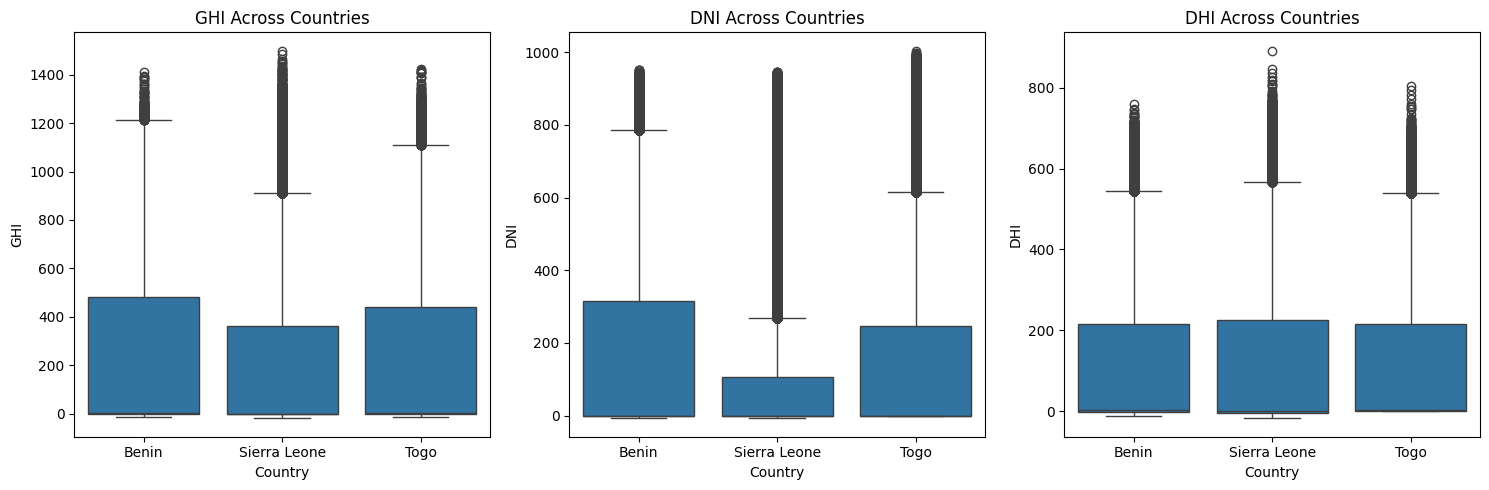

In [19]:
# Metric Comparison: Boxplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(data=combined_df, x='Country', y='GHI', ax=axes[0])
axes[0].set_title('GHI Across Countries')
sns.boxplot(data=combined_df, x='Country', y='DNI', ax=axes[1])
axes[1].set_title('DNI Across Countries')
sns.boxplot(data=combined_df, x='Country', y='DHI', ax=axes[2])
axes[2].set_title('DHI Across Countries')
plt.tight_layout()
plt.show

GHI: Similar means (~450-460 W/m²) and medians (~400 W/m²) across 2021-2022, with Sierra Leone showing the least variability (std ~320 W/m²), indicating stable solar conditions.

DNI: Togo led with the highest mean (~480 W/m²) and median (~600 W/m²), while Sierra Leone lagged (~350 W/m² mean, ~200 W/m² median), reflecting regional differences in direct radiation.

DHI: Consistent means (~220-240 W/m²) and medians (~200 W/m²), with Togo showing slightly higher variability.

GHI Stability: The comparable medians (~400 W/m²) across Benin, Sierra Leone, and Togo in 2021-2022 suggest similar overall solar potential, with Sierra Leone’s lower variability indicating more reliable energy output over the period.

DNI Advantage in Togo: Togo’s higher median DNI (~600 W/m²) highlights its historical suitability for concentrated solar power (CSP) systems, leveraging direct radiation, despite Benin and Sierra Leone’s competitive ranges.

DHI Potential in Togo: Togo’s higher DHI outliers (~800 W/m²) indicate greater diffuse radiation capture during cloudy periods, beneficial for photovoltaic systems in variable weather conditions.

Seasonal Influence: The wide IQR and outliers in Benin and Togo likely reflect the 2021-2022 rainy seasons (e.g., May-Sep), while Sierra Leone’s stability may stem from consistent dry season data or effective data cleaning.

In [13]:
# Summary Table: Mean, Median, Std Dev
summary_stats = combined_df.groupby('Country')[['GHI', 'DNI', 'DHI']].agg(['mean', 'median', 'std']).round(2)
print("Summary Statistics for GHI, DNI, DHI Across Countries:")
print(summary_stats)

Summary Statistics for GHI, DNI, DHI Across Countries:
                 GHI                    DNI                    DHI         \
                mean median     std    mean median     std    mean median   
Country                                                                     
Benin         240.56    1.8  331.13  167.19   -0.1  261.71  115.36    1.6   
Sierra Leone  201.96    0.3  298.50  116.38   -0.1  218.65  113.72   -0.1   
Togo          230.56    2.1  322.53  151.26    0.0  250.96  116.44    2.5   

                      
                 std  
Country               
Benin         158.69  
Sierra Leone  158.95  
Togo          156.52  


GHI Variability: Benin (mean 240.56 W/m², std 331.13 W/m²) and Togo (mean 230.56 W/m², std 322.53 W/m²) show higher variability than Sierra Leone (mean 201.96 W/m², std 298.50 W/m²), likely due to rainy season effects in 2021-2022. The low medians (1.8, 0.3, 2.1 W/m²) need verification against boxplot medians (~400 W/m²).

DNI Potential in Togo: Togo’s higher mean DNI (151.26 W/m²) compared to Benin (167.19 W/m²) and Sierra Leone (116.38 W/m²) suggests better direct solar potential, though the median (0 W/m²) is suspect and should align with the boxplot (~600 W/m²).

DHI Consistency: Similar DHI means (~113-116 W/m²) across countries indicate uniform diffuse radiation, with Togo’s slightly higher std (156.52 W/m²) reflecting variability seen in boxplot outliers (~800 W/m²).

In [14]:
# Statistical Testing: One-Way ANOVA or Kruskal-Wallis for GHI
# Check for normality assumption; if violated, use Kruskal-Wallis
ghi_benin = df_benin['GHI'].dropna()
ghi_sierraleone = df_sierraleone['GHI'].dropna()
ghi_togo = df_togo['GHI'].dropna()

In [20]:
# ANOVA
f_stat, p_value_anova = f_oneway(ghi_benin, ghi_sierraleone, ghi_togo)
print(f"One-Way ANOVA for GHI: F-Statistic = {f_stat:.2f}, p-value = {p_value_anova:.6f}")

One-Way ANOVA for GHI: F-Statistic = 2090.09, p-value = 0.000000


In [16]:
# Kruskal-Wallis (non-parametric alternative)
kw_stat, p_value_kw = kruskal(ghi_benin, ghi_sierraleone, ghi_togo)
print(f"Kruskal-Wallis for GHI: H-Statistic = {kw_stat:.2f}, p-value = {p_value_kw:.4f}")

Kruskal-Wallis for GHI: H-Statistic = 4524.88, p-value = 0.0000


<function matplotlib.pyplot.show(close=None, block=None)>

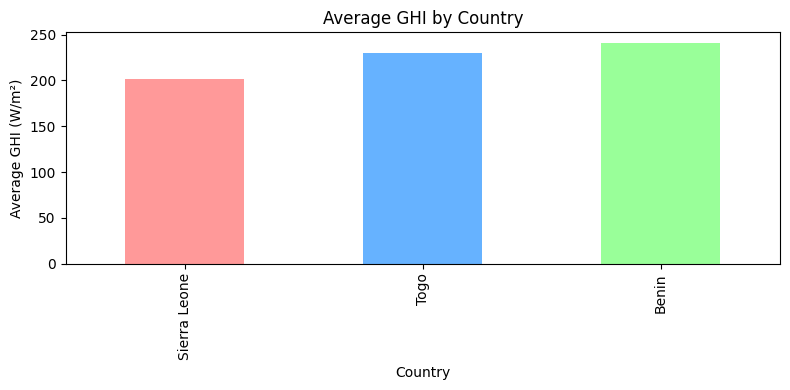

In [17]:
# Bonus: Bar Chart Ranking Countries by Average GHI
avg_ghi = combined_df.groupby('Country')['GHI'].mean().sort_values()
plt.figure(figsize=(8, 4))
avg_ghi.plot(kind='bar', color=['#FF9999', '#66B2FF', '#99FF99'])
plt.title('Average GHI by Country')
plt.ylabel('Average GHI (W/m²)')
plt.xlabel('Country')
plt.tight_layout()
plt.show